# Global Temperature Time Series Forecasting using XGBoost

In this notebook, we will walk through Global Temperature Time Series Forecasting using XGBoost. The data we will be using is the documentation of Mean Global Temperatures for every year, available for the time period 1750 -2015.

# Data
The data we will be using is the the documentation of the Mean Global Temperatures collected from Kaggle. 

# Intel Technologies used:

XGBoost:
XGBoost is an open source gradient boosting machine learning library. It performs well across a variety of data and problem types, so it often pushes the limits of compute resources.

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# Reading the CSV file and Eliminating Null Values
The pandas library of Python can be used in order to create the data frame out of the csv file which would be used for further analysis in the project. The presence of null values in the dataset reduce the accuracy of models, so we need to eliminated them. Here, we have used the ffill (forward fill) and the bfill(backward fill) methods for this purpose.

In [41]:
data = pd.read_csv('/Users/akhil/Projects/GlobalTempPrediction/GlobalTemperatures.csv', index_col=[0], parse_dates=[0])

In [42]:
data.fillna(method='ffill', inplace = True)
data.LandAverageTemperature.fillna(method = 'bfill', inplace = True)

# Reducing the number of unimportant parameters
In order to reduce the complexity of this model, we have reuduced the number of parameters we have considered to build the model. We have used the LandAverageTemp and the date section as the input columns. The restof the columns have been dropped using the .drop() function.

In [43]:
data=data.drop(['LandAverageTemperatureUncertainty'],axis=1)
data=data.drop(['LandMaxTemperature'],axis=1)
data=data.drop(["LandMaxTemperatureUncertainty"],axis=1)
data=data.drop(["LandMinTemperature"],axis=1)
data=data.drop(["LandMinTemperatureUncertainty"],axis=1)
data=data.drop(["LandAndOceanAverageTemperature"],axis=1)
data=data.drop(["LandAndOceanAverageTemperatureUncertainty"],axis=1)

# Renaming the columns from time and temperature_average(tavg)

In [44]:
data.rename(columns = {'dt':'ds','LandAverageTemperature':'y'}, inplace = True)

# Visualization of Mean Global Temperature vs Time
A scatter plot of Mean Global Temperature vs Time was developed using the matplotlib in python. 

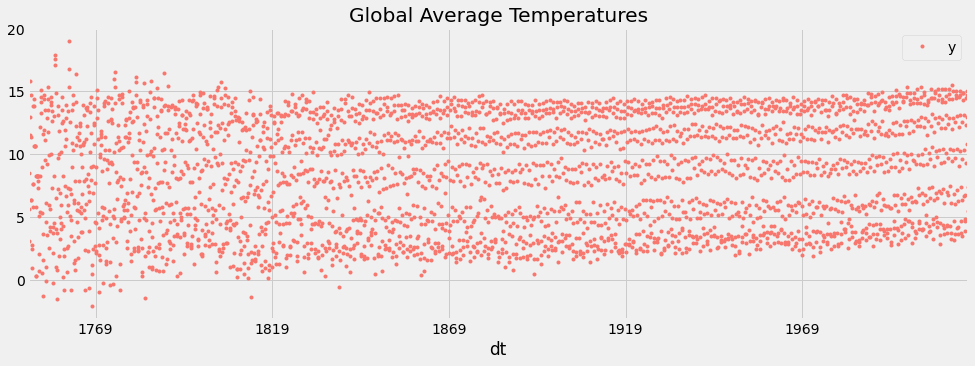

In [45]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='.', figsize=(15,5), color=color_pal[0], title='Global Average Temperatures')

# Train/Test Split
The dataset was split into  Training and and Testing datasets. The original dataset was cutoff after 1969 to use as a validation set.

In [46]:
split_date = '01-Jan-1969'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# Visualization of Training and Testing Datasets vs Time
A scatter plot was created for Mean Global Temperatures vs Time with the training and testing datasets distinguished
using the legend:


Blue:Testing data


Orange: Training data

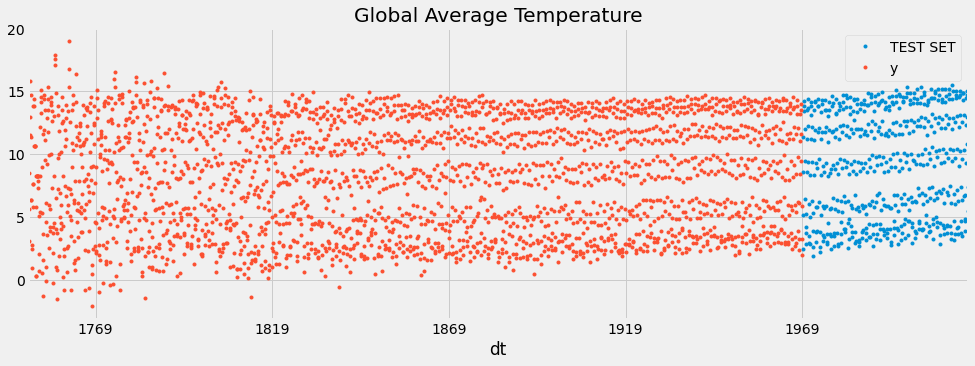

In [47]:
_ = data_test \
    .rename(columns={'y': 'TEST SET'}) \
    .join(data_train.rename(columns={'ds': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Global Average Temperature', style='.')

# Time Series Features
The Date feature of the data frame has been used in order to extract the following features:
1. hour
2. dayofweek
3. quarter
4. month
5. year
6. dayofyear
7. dayofmonth
8. weekofyear

These features will be used in order to train the model and to understand at which of these features is there a major change in the temperature occuring. 

In [48]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [49]:
X_train, y_train = create_features(data_train, label='y')
X_test, y_test = create_features(data_test, label='y')

/var/folders/gz/mfxnbqrs2mz5gtwftbjq52640000gn/T/ipykernel_5432/256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/gz/mfxnbqrs2mz5gtwftbjq52640000gn/T/ipykernel_5432/256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


# Create XGBoost Model
XGBoost or eXtreme Gradient Boosting library in python which has become one of the most popular ML algorithm due to its ability to handle large datasets and its ability to achieve state-of-the-art performance in many machine learning tasks such as classification and regression. It has the ability to work with real world data sets which have missing values and an allow parallel processing.

Now, we are building the XGB model for our project, with data fed in as training and testing data.

In [50]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:6.26325	validation_1-rmse:6.92949
[1]	validation_0-rmse:4.43997	validation_1-rmse:5.06804
[2]	validation_0-rmse:3.17978	validation_1-rmse:3.76098
[3]	validation_0-rmse:2.31692	validation_1-rmse:2.85245
[4]	validation_0-rmse:1.73697	validation_1-rmse:2.21422
[5]	validation_0-rmse:1.35582	validation_1-rmse:1.78038
[6]	validation_0-rmse:1.10977	validation_1-rmse:1.49495
[7]	validation_0-rmse:0.95863	validation_1-rmse:1.24875
[8]	validation_0-rmse:0.86167	validation_1-rmse:1.09059
[9]	validation_0-rmse:0.79882	validation_1-rmse:0.99040
[10]	validation_0-rmse:0.74853	validation_1-rmse:0.92172
[11]	validation_0-rmse:0.71645	validation_1-rmse:0.86869
[12]	validation_0-rmse:0.69956	validation_1-rmse:0.83575
[13]	validation_0-rmse:0.68193	validation_1-rmse:0.80988
[14]	validation_0-rmse:0.66959	validation_1-rmse:0.79532
[15]	validation_0-rmse:0.65570	validation_1-rmse:0.78111
[16]	validation_0-rmse:0.64733	validation_1-rmse:0.77372
[17]	validation_0-rmse:0.63009	validation

/Users/akhil/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-rmse:0.44097	validation_1-rmse:0.75158
[44]	validation_0-rmse:0.43490	validation_1-rmse:0.75151
[45]	validation_0-rmse:0.42897	validation_1-rmse:0.75012
[46]	validation_0-rmse:0.42335	validation_1-rmse:0.74952
[47]	validation_0-rmse:0.41814	validation_1-rmse:0.74977
[48]	validation_0-rmse:0.41279	validation_1-rmse:0.74991
[49]	validation_0-rmse:0.40899	validation_1-rmse:0.74973
[50]	validation_0-rmse:0.40773	validation_1-rmse:0.74975
[51]	validation_0-rmse:0.40266	validation_1-rmse:0.74959
[52]	validation_0-rmse:0.39623	validation_1-rmse:0.75000
[53]	validation_0-rmse:0.39103	validation_1-rmse:0.75015
[54]	validation_0-rmse:0.38814	validation_1-rmse:0.74967
[55]	validation_0-rmse:0.38746	validation_1-rmse:0.75149
[56]	validation_0-rmse:0.38247	validation_1-rmse:0.75163
[57]	validation_0-rmse:0.37458	validation_1-rmse:0.75213
[58]	validation_0-rmse:0.37180	validation_1-rmse:0.75410
[59]	validation_0-rmse:0.37057	validation_1-rmse:0.75483
[60]	validation_0-rmse:0.36919	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the year was most commonly used to split trees, while dayofweek and month came in next. 

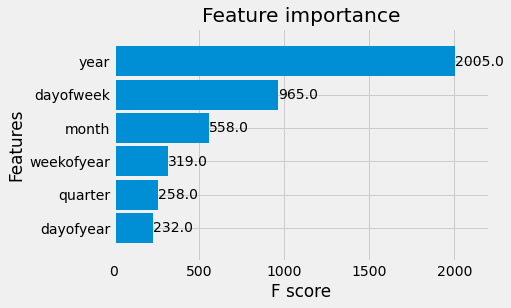

In [51]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set
Now we run the model with just the testing data in order to check the validation of the model.

In [52]:
data_test['y_prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

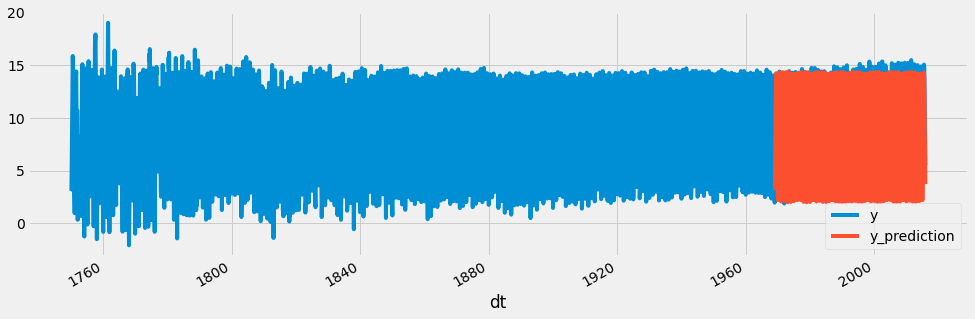

In [53]:
_ = data_all[['y','y_prediction']].plot(figsize=(15, 5))

# Looking at one year of predictions
By looking the one year predictions for 1969-1970 and 2012-2013, we tend to notice a change in how the prediction aligns with the actual data values. For 1969-1970, the predicted line overlaps and is in sync with the actual data points, this shows that the data pattern of the actual values is consistent in this duration. Whereas, in 2012-2013 there is a lot of error between the predicted data and actual data values, we see a pattern where all the data points in the actual data are higher than the predicted ones. Therefore, we know that the model is not overfitting as, in this duration the predicted values would overlap the actual ones. The reason behind the slight deviation is Global Warming, which is accelerating the increase in mean global temperature towards to end of the data set.

## In the graph below, the predicted graph is quite consistent with acutal data points

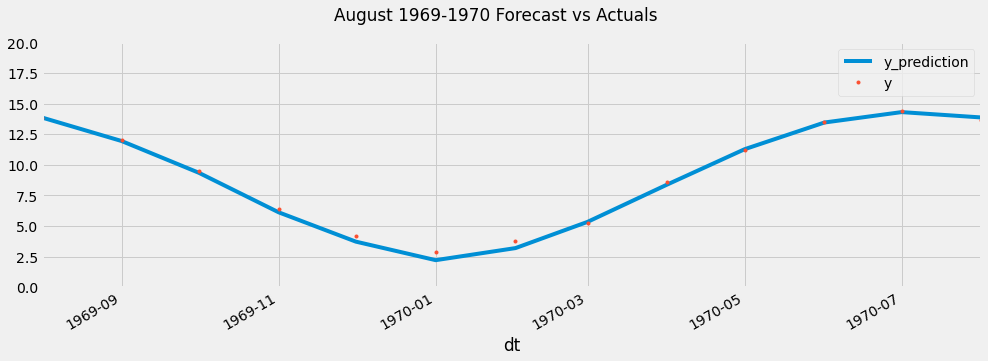

In [54]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-1969', upper='08-01-1970')
ax.set_ylim(0, 20)
plot = plt.suptitle('August 1969-1970 Forecast vs Actuals')

## In the graph below, the predicted graph is slightly deviating below the actual data values

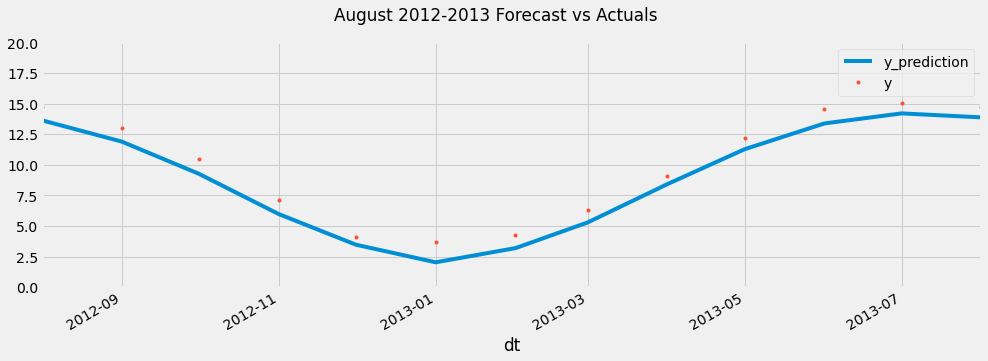

In [55]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2012', upper='08-01-2013')
ax.set_ylim(0, 20)
plot = plt.suptitle('August 2012-2013 Forecast vs Actuals')

## Visualization of Training and Testing Data Sets 

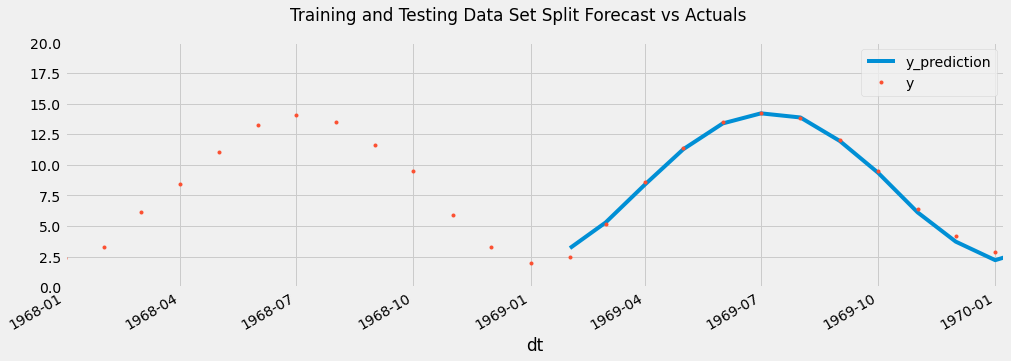

In [56]:
# Plot the forecast with the actual values
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-1968', upper='01-08-1970')
ax.set_ylim(0, 20)
plot = plt.suptitle('Training and Testing Data Set Split Forecast vs Actuals')

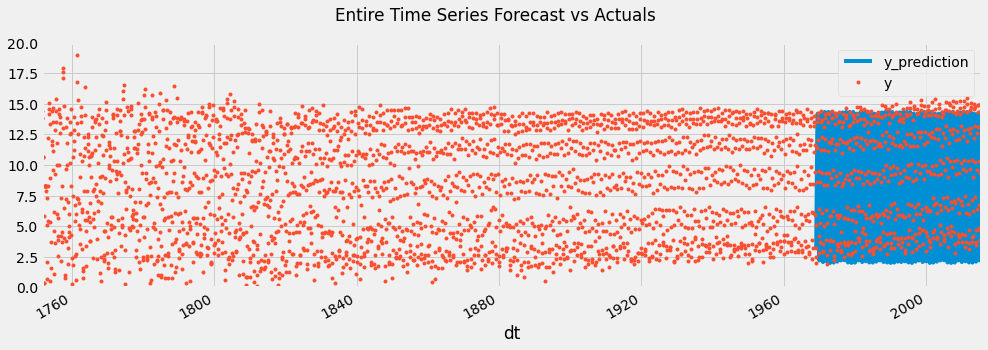

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 20)
ax.set_xbound(lower='07-01-1751', upper='07-08-2015')
plot = plt.suptitle('Entire Time Series Forecast vs Actuals')

# Error Metrics On Test Set
Our MSE error is approximately 0.558  

Our MAE error is approximately 0.610 

Our MAPE error is approximately 9.5%

In [58]:
mean_squared_error(y_true=data_test['y'],
                   y_pred=data_test['y_prediction'])

0.5576423722667995

In [59]:
mean_absolute_error(y_true=data_test['y'],
                   y_pred=data_test['y_prediction'])

0.6100793526854438

### Using mean absolute percent error gives an easy way to interperate percentage showing how off the predictions are.

In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
mean_absolute_percentage_error(y_true=data_test['y'],
                   y_pred=data_test['y_prediction'])

9.54155861753418

# More Data on Forecasted Days

In [63]:
data_test['error'] = data_test['y'] - data_test['y_prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['y','y_prediction','error','abs_error']]

In [64]:
# Over forecasted durations
error_by_day.sort_values('error', ascending=True).head(10)

,,,y,y_prediction,error,abs_error
year,month,dayofmonth,,,,
1976,10,1,8.511,9.258760,-0.747760,0.747760
1969,2,1,2.450,3.187178,-0.737178,0.737178
1976,3,1,4.517,5.239720,-0.722720,0.722720
1974,2,1,2.582,3.187178,-0.605178,0.605178
1978,8,1,13.297,13.872503,-0.575503,0.575503
1972,2,1,2.609,3.150330,-0.541330,0.541330
1985,2,1,2.704,3.187178,-0.483178,0.483178
1976,6,1,13.086,13.489117,-0.403117,0.403117
1993,11,1,5.738,6.124891,-0.386891,0.386891


In [65]:
# Worst absolute predicted duration
error_by_day.sort_values('abs_error', ascending=False).head(10)

y  y_prediction     error  abs_error
year month dayofmonth                                          
2007 1     1           4.579      1.999253  2.579747   2.579747
2002 1     1           4.026      2.026386  1.999614   1.999614
2003 1     1           3.981      2.103963  1.877037   1.877037
2015 12    1           5.518      3.721894  1.796106   1.796106
     1     1           3.881      2.201882  1.679118   1.679118
2010 1     1           3.737      2.072782  1.664218   1.664218
2013 1     1           3.685      2.026386  1.658614   1.658614
1998 2     1           4.826      3.188251  1.637749   1.637749
2014 1     1           3.732      2.103963  1.628037   1.628037
2005 1     1           3.808      2.220092  1.587908   1.587908

In [66]:
# Best predicted durations
error_by_day.sort_values('abs_error', ascending=True).head(10)

y  y_prediction     error  abs_error
year month dayofmonth                                           
1973 8     1           13.869     13.867027  0.001973   0.001973
1972 10    1            9.346      9.340013  0.005987   0.005987
1970 10    1            9.348      9.341501  0.006499   0.006499
1985 9     1           11.980     11.971142  0.008858   0.008858
     10    1            9.338      9.346977 -0.008977   0.008977
1974 6     1           13.382     13.372222  0.009778   0.009778
1972 9     1           11.901     11.890737  0.010263   0.010263
1989 5     1           11.280     11.292990 -0.012990   0.012990
2004 7     1           14.312     14.298154  0.013846   0.013846
1971 8     1           13.879     13.861121  0.017879   0.017879

# Plotting some best/worst predicted durations

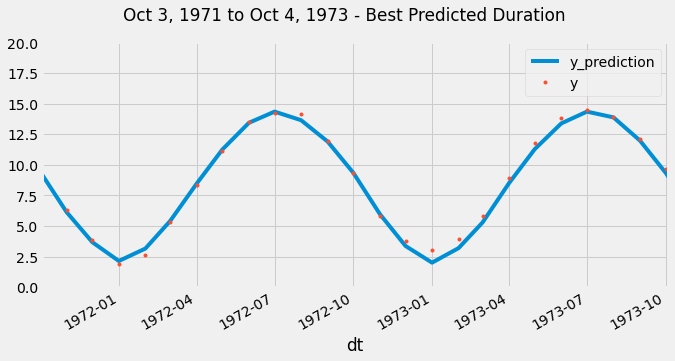

In [67]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 20)
ax.set_xbound(lower='10-03-1971', upper='10-04-1973')
plot = plt.suptitle('Oct 3, 1971 to Oct 4, 1973 - Best Predicted Duration')

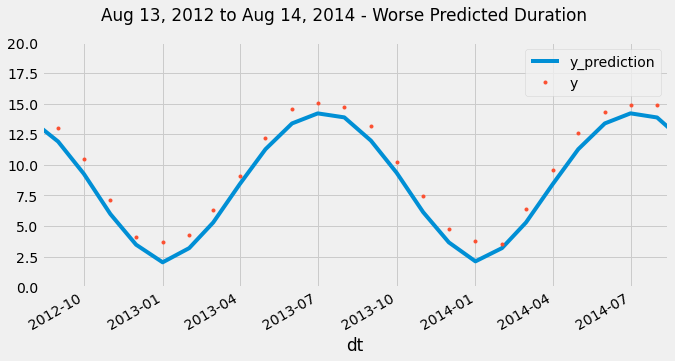

In [68]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 20)
ax.set_xbound(lower='08-13-2012', upper='08-14-2014')
plot = plt.suptitle('Aug 13, 2012 to Aug 14, 2014 - Worse Predicted Duration')

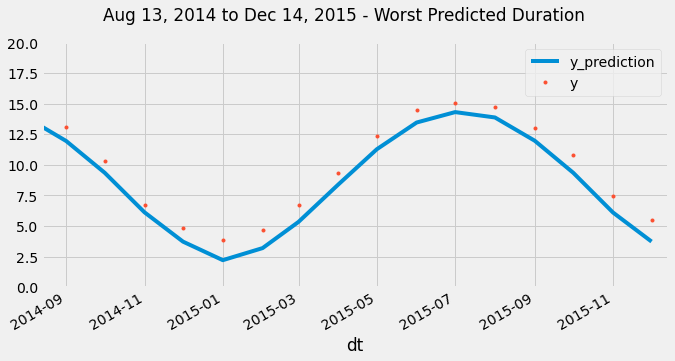

In [69]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['y_prediction','y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 20)
ax.set_xbound(lower='08-13-2014', upper='12-14-2015')
plot = plt.suptitle('Aug 13, 2014 to Dec 14, 2015 - Worst Predicted Duration')